In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=c41edf9d100a4b8ad826743ad38842800fa846259c94d7f118dc8c9dedd0597d
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
import numpy as np
from scipy.spatial.distance import cosine
import os
from deepface import DeepFace
import cv2
from collections import deque
from google.colab.patches import cv2_imshow
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

25-03-10 08:09:13 - Directory /root/.deepface has been created
25-03-10 08:09:13 - Directory /root/.deepface/weights has been created


In [ ]:
models = [
  "VGG-Face",
  "Facenet",
  "Facenet512",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace",
  "Dlib",
  "SFace",
  "GhostFaceNet"
]
backends = [
  'opencv',
  'ssd',
  'dlib',
  'mtcnn',
  'fastmtcnn',
  'retinaface',
  'mediapipe',
  'yolov8',
  'yolov11s',
  'yolov11n',
  'yolov11m',
  'yunet',
  'centerface',
]

sim=lambda x: 1-x/2

In [ ]:
anshuman = np.load('anshuman.npy')

# Check the shape and type of the loaded array
print(anshuman.shape, anshuman.dtype)
profiles=[anshuman]

(512,) float64


CSV file saved: processed_compass_data.csv


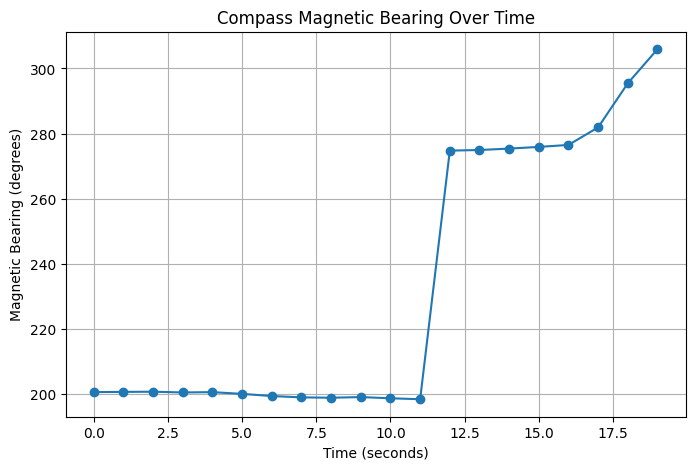

[{'seconds_elapsed': 0, 'degree': 200.54517498027806}, {'seconds_elapsed': 1, 'degree': 200.62046057586124}, {'seconds_elapsed': 2, 'degree': 200.66770084270823}, {'seconds_elapsed': 3, 'degree': 200.44410438138186}, {'seconds_elapsed': 4, 'degree': 200.54050654604026}, {'seconds_elapsed': 5, 'degree': 200.00419649384173}, {'seconds_elapsed': 6, 'degree': 199.33770605691822}, {'seconds_elapsed': 7, 'degree': 198.93306166222072}, {'seconds_elapsed': 8, 'degree': 198.82288881957126}, {'seconds_elapsed': 9, 'degree': 199.02304850742183}, {'seconds_elapsed': 10, 'degree': 198.6498857526931}, {'seconds_elapsed': 11, 'degree': 198.36388761213578}, {'seconds_elapsed': 12, 'degree': 274.74423457533015}, {'seconds_elapsed': 13, 'degree': 274.9349382935289}, {'seconds_elapsed': 14, 'degree': 275.3697896626555}, {'seconds_elapsed': 15, 'degree': 275.88566034220474}, {'seconds_elapsed': 16, 'degree': 276.49347304806605}, {'seconds_elapsed': 17, 'degree': 281.8891588242028}, {'seconds_elapsed': 18,

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def process_compass_data(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)

    # Extract compass readings
    compass_data = [entry for entry in data if entry["sensor"] == "Compass"]

    # Group readings into 1-second intervals
    aggregated_data = []
    start_time = float(compass_data[0]["seconds_elapsed"])  # Get the first timestamp
    interval = 1.0  # 1-second interval
    temp_values = []

    for entry in compass_data:
        elapsed_time = float(entry["seconds_elapsed"])
        magnetic_bearing = float(entry["magneticBearing"])

        if elapsed_time < start_time + interval:
            temp_values.append(magnetic_bearing)
        else:
            # Compute average for the previous interval
            if temp_values:
                avg_bearing = np.mean(temp_values)
                aggregated_data.append({"seconds_elapsed": round(start_time), "degree": avg_bearing})
            # Move to the next interval
            start_time += interval
            temp_values = [magnetic_bearing]  # Start new interval

    # Add the last interval data if any
    if temp_values:
        avg_bearing = np.mean(temp_values)
        aggregated_data.append({"seconds_elapsed": round(start_time), "degree": avg_bearing})

    return aggregated_data

def plot_compass_data(data):
    seconds = [entry["seconds_elapsed"] for entry in data]
    degrees = [entry["degree"] for entry in data]

    plt.figure(figsize=(8, 5))
    plt.plot(seconds, degrees, marker='o', linestyle='-')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Magnetic Bearing (degrees)")
    plt.title("Compass Magnetic Bearing Over Time")
    plt.grid(True)
    plt.show()
def convert_json_to_csv(processed_data, csv_path="processed_compass_data.csv",start=0,end=float('inf')):
    df = pd.DataFrame(processed_data)
    df.rename(columns={"degree": "compass"}, inplace=True)  # Rename column for motion detection
    df = df[(df["seconds_elapsed"] >= start) & (df["seconds_elapsed"] <= end)]
    df["seconds_elapsed"] = df["seconds_elapsed"] - start
    df.to_csv(csv_path, index=False)
    print(f"CSV file saved: {csv_path}")


file_path = '/content/2025-03-10_11-59-58.json'
processed_data = process_compass_data(file_path)
convert_json_to_csv(processed_data, "processed_compass_data.csv",4,15)
plot_compass_data(processed_data)
print(processed_data)

In [ ]:
def check(frame, profiles=profiles):
    try:
        embeddingTest = DeepFace.represent(frame, model_name=models[2], detector_backend=backends[5])
        embeddingTest = [np.array(embeddingTest[i]['embedding']) for i in range(len(embeddingTest))]
        for a in embeddingTest:
            for b in profiles:
                print(sim(cosine(a, b)))
        return any(sim(cosine(a, b)) >= 0.77 for a in embeddingTest for b in profiles)
    except:
        return False
def detect_motion(csv_path="/content/processed_compass_data.csv", default_reading=200, curr_sec=0):
        df = pd.read_csv(csv_path)  # Load the CSV file
        df = df.sort_values(by=['seconds_elapsed'])  # Ensure it's sorted by time

        closest_sec = df.iloc[(df['seconds_elapsed'] - curr_sec).abs().argsort()[0]]  # Find the closest second
        current_reading = closest_sec["compass"]  # Get the corresponding compass reading
       # print(current_reading,curr_sec)
        return abs(current_reading - default_reading) > 10  # Motion detected if difference > 10


def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_queue = deque(maxlen=5)  # Store last x frames
    recent_checked_frame = [False, 0]
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = fps  # One frame per second
    frame_no = 0
    #print(fps,frame_interval)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_no % frame_interval == 0:
            motion_detected = detect_motion(curr_sec=frame_no//fps)
            if motion_detected:

                print(f"Motion detected at second {frame_no // fps}",frame_no)
                true_count = 0
                if recent_checked_frame[0] is not False and frame_no - recent_checked_frame[0] <= fps * 10:
                    frame_no += 1
                    continue
                else:
                    for frame in frame_queue:
                        cv2_imshow(frame)
                        if check(frame):
                            true_count += 1
                            if true_count >= 1:
                                print('Valid entry')
                                break

                    recent_checked_frame = [frame_no, true_count]
                    if true_count <1:
                        print(f"Unidentified person triggered at second {frame_no // fps}")
            frame_queue.append(frame)
        frame_no += 1

    cap.release()
    cv2.destroyAllWindows()


CSV file saved: processed_compass_data.csv
Motion detected at second 12 324


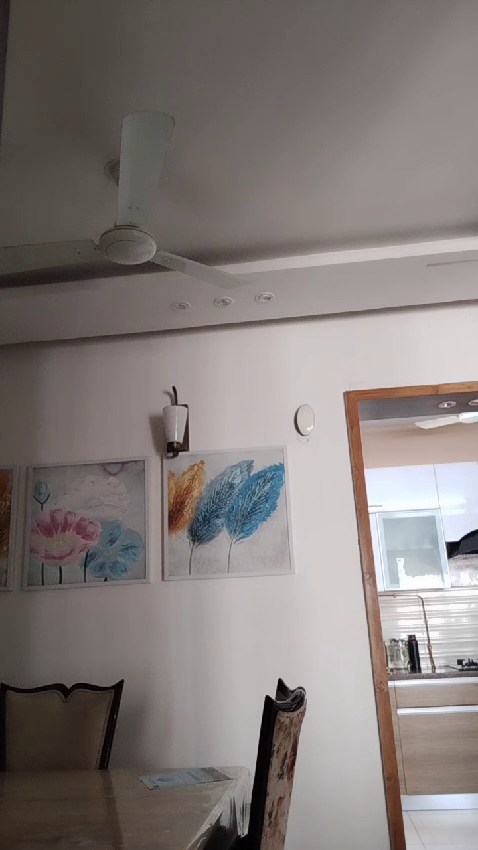

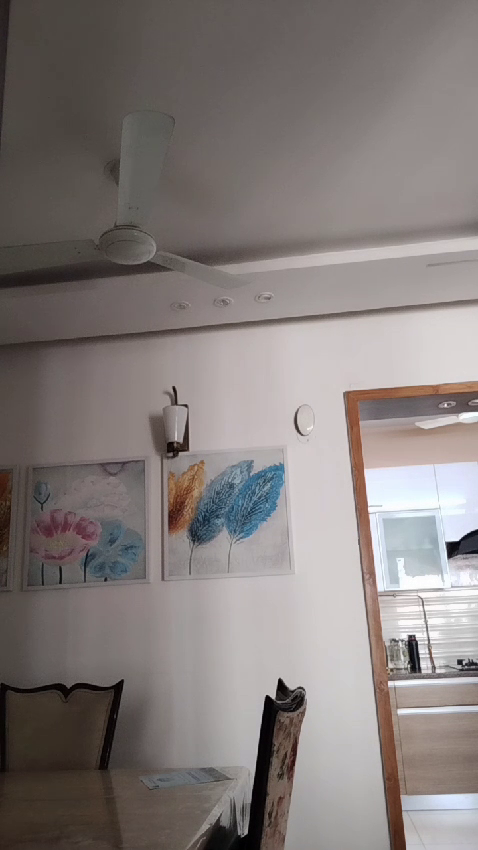

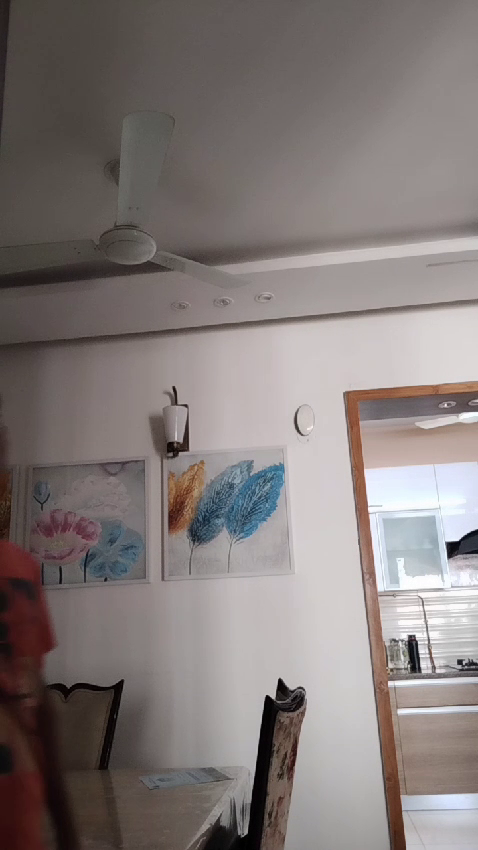

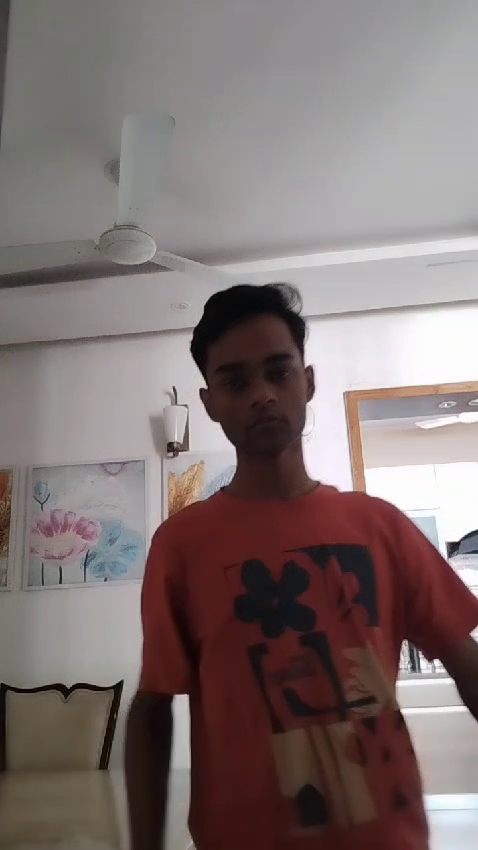

0.8032238553294057
Valid entry
Motion detected at second 13 351
Motion detected at second 14 378


In [ ]:
file_path = '/content/2025-03-10_07-53-30.json'
processed_data = process_compass_data(file_path)
convert_json_to_csv(processed_data, "processed_compass_data.csv",10,25)
process_video(video_path='/content/WhatsApp Video 2025-03-10 at 13.25.34.mp4')

CSV file saved: processed_compass_data.csv
Motion detected at second 8 240


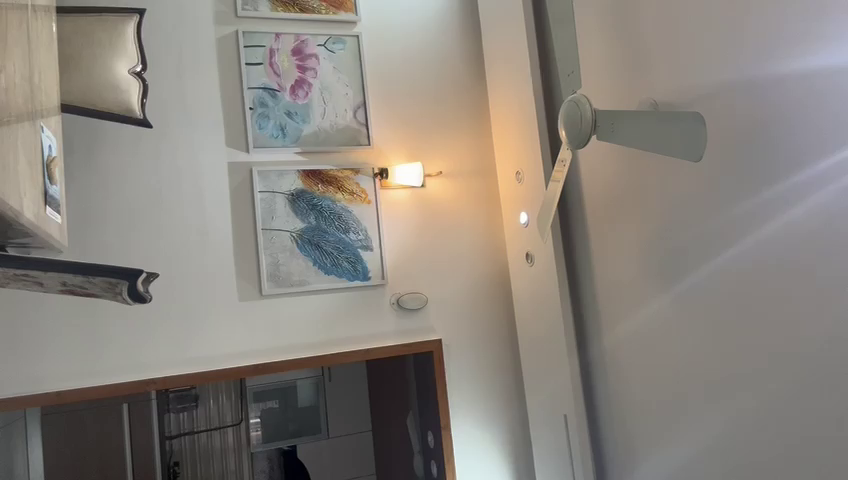

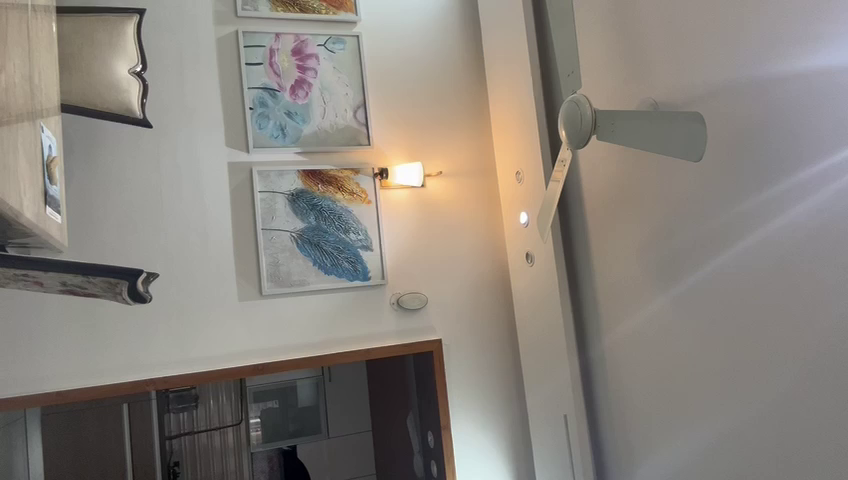

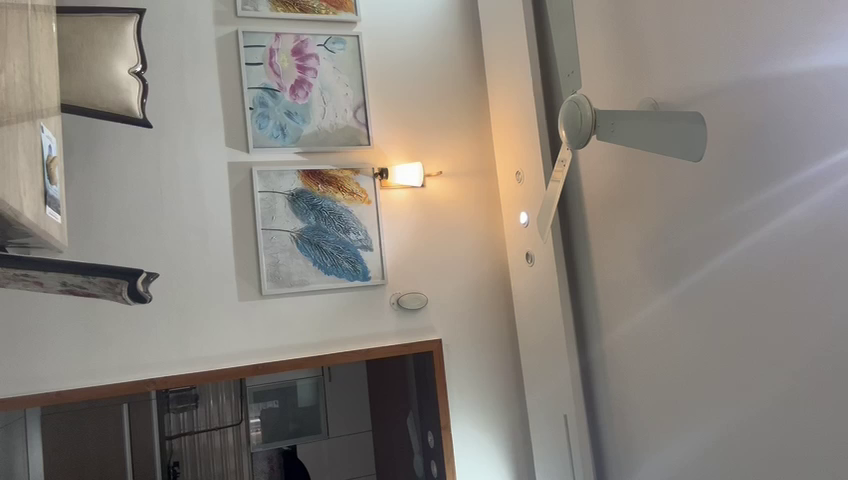

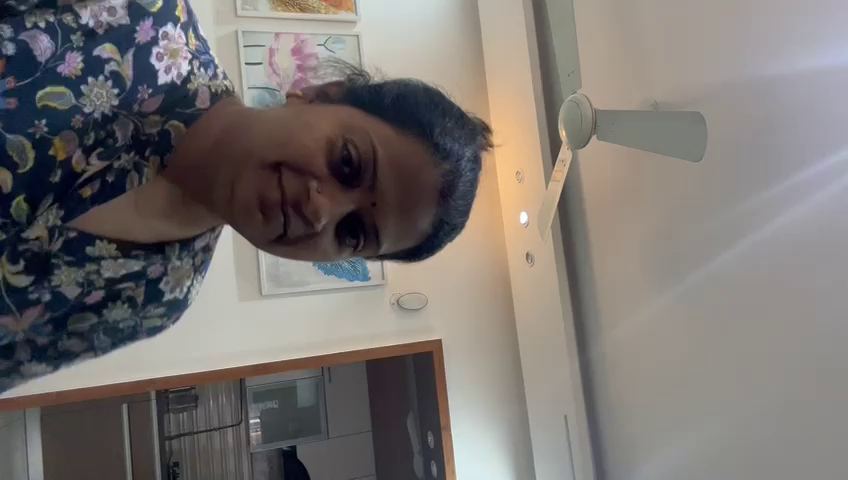

0.5750860795208124


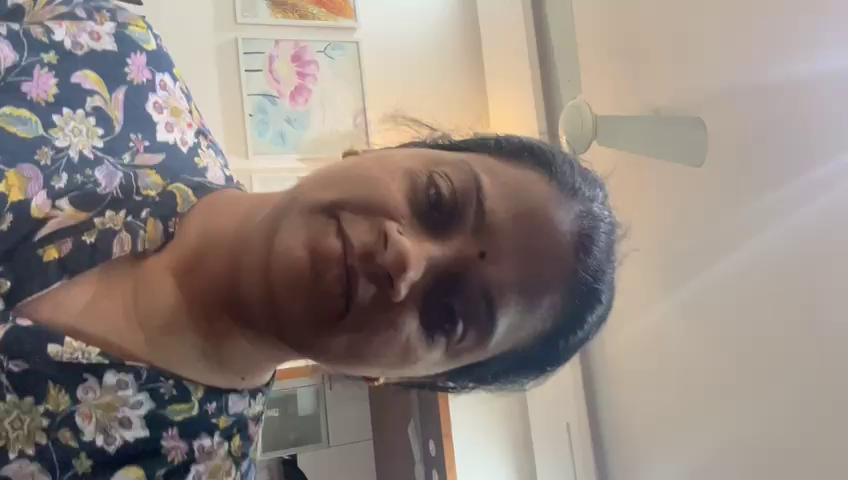

0.6524684124923528
Unidentified person triggered at second 8
Motion detected at second 9 270
Motion detected at second 10 300


In [ ]:
file_path = '/content/2025-03-10_11-59-58.json'
processed_data = process_compass_data(file_path)
convert_json_to_csv(processed_data, "processed_compass_data.csv",4,15)
process_video(video_path='/content/archana single.mp4')

In [ ]:
# @title Default title text
archana=[]
folder_path = "/content/archana"
for img_name in os.listdir(folder_path):
  img_path = os.path.join(folder_path, img_name)
  try:
    embImg=DeepFace.represent(img_path,model_name=models[2],detector_backend = backends[5])
    embImg=[np.array(embImg[i]['embedding']) for i in range(len(embImg))]
    archana.append(embImg[0])
  except:
    continue

archana = np.mean(np.stack(archana), axis=0)
np.save('archana.npy',archana)

In [ ]:
archana = np.load('archana.npy')
profiles.append(archana)

CSV file saved: processed_compass_data.csv
Motion detected at second 8 240


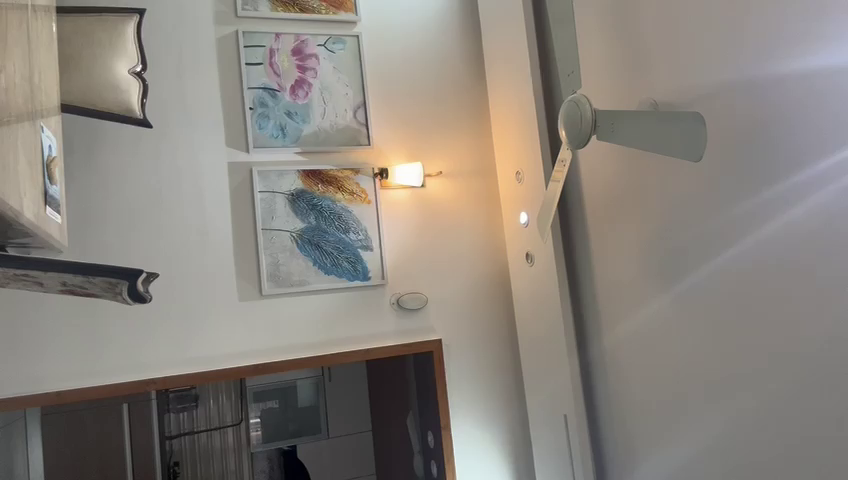

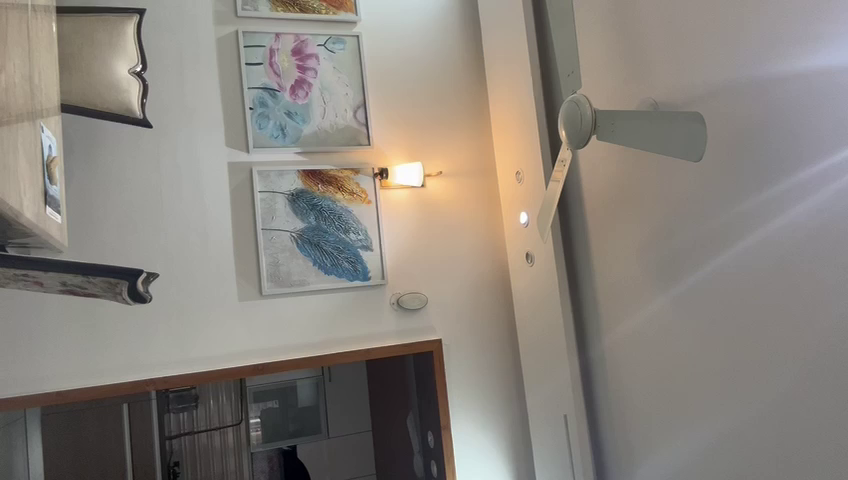

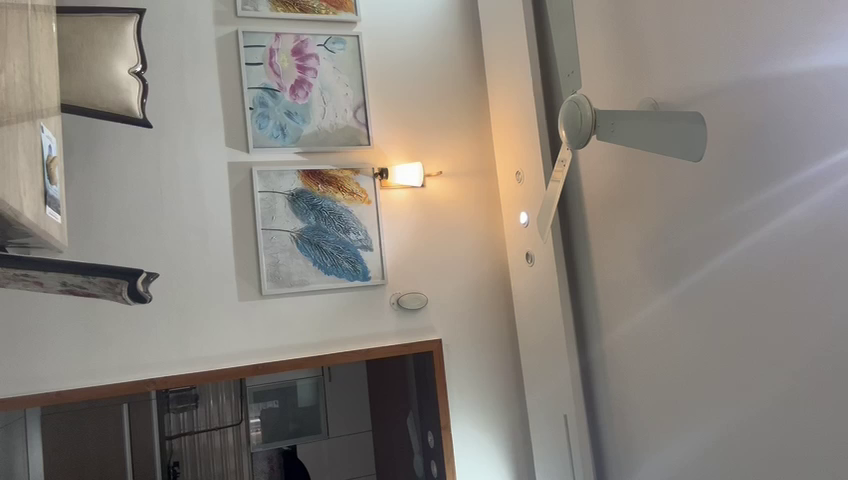

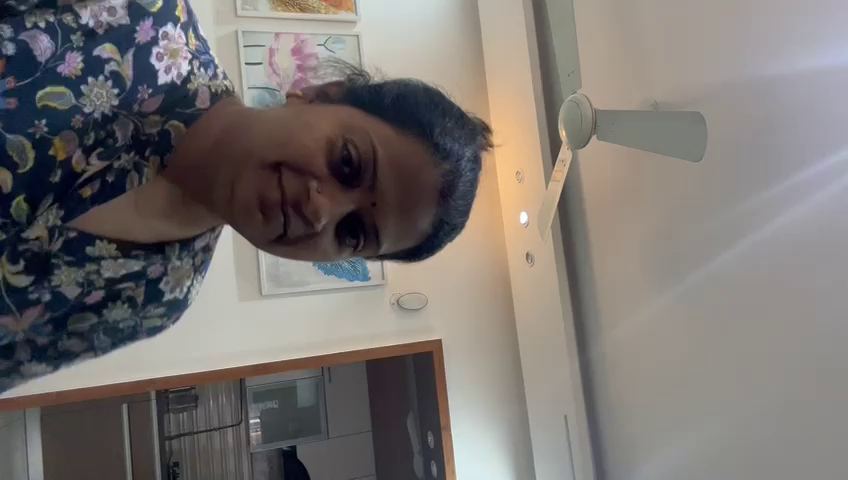

0.5750860795208124
0.8611493794453113
Valid entry
Motion detected at second 9 270
Motion detected at second 10 300


In [ ]:
file_path = '/content/2025-03-10_11-59-58.json'
processed_data = process_compass_data(file_path)
convert_json_to_csv(processed_data, "processed_compass_data.csv",4,15)
process_video(video_path='/content/archana single.mp4')